# Clustering y regionalización


Muchos fenómenos del mundo real son complejos y están determinados por múltiples factores que actúan al mismo tiempo. En estadística, estos se conocen como **procesos multivariados**, a diferencia de los **univariados**, donde solo interviene una variable.

El **análisis de clústeres** es una herramienta clave en el análisis geográfico que permite identificar patrones de similitud entre varias dimensiones y resumir esa complejidad en representaciones más simples. Esto facilita la comprensión de procesos complejos, incluso por parte de audiencias no técnicas.


## Introducción


El análisis de clústeres es una técnica de aprendizaje estadístico **no supervisado** que agrupa observaciones sin categorías predefinidas. Su objetivo es formar **conglomerados** de elementos similares entre sí, diferenciándolos de otros grupos. Cada clúster se puede describir mediante un **perfil** que resume sus características comunes dentro de un fenómeno multivariado.

Como los elementos de un clúster son similares entre sí, su **perfil** permite resumir eficazmente un fenómeno multivariado complejo. En lugar de analizar todas las variables por separado, basta con observar el perfil del grupo. Este enfoque es ampliamente usado en ciencia de datos geográfica para entender la estructura espacial de datos complejos y multivariados.

En el análisis espacial, una **región** funciona de forma similar a un clúster, ya que agrupa elementos con perfiles similares. La diferencia clave es que una región también incorpora información sobre la **ubicación** de sus elementos. Es decir, además de compartir características, los miembros de una región están vinculados espacialmente, lo que la hace útil para representar tanto contenido como contexto geográfico.


La **regionalización** es un tipo de agrupamiento que considera tanto la similitud estadística como la ubicación espacial de las observaciones. A diferencia del clustering convencional, impone **restricciones geográficas**, como la conectividad entre los elementos de una misma región. Estas condiciones pueden ajustarse según el contexto analítico.


En este capítulo se abordan técnicas de **clustering** y **regionalización**, aplicadas al análisis de datos socioeconómicos. Trabajaremos con información del **Censo de Población y Vivienda de 2010 del Ecuador**, disponible en el siguiente enlace:

[https://raw.githubusercontent.com/vmoprojs/DataLectures/refs/heads/master/SpatialData/indicadoresCantonalesEC.csv](https://raw.githubusercontent.com/vmoprojs/DataLectures/refs/heads/master/SpatialData/indicadoresCantonalesEC.csv)

Este conjunto de datos contiene indicadores cantonales como:

- `id`: Identificador de la división político-administrativa del cantón  
- `can`: Nombre del cantón  
- `pob`: Porcentaje de personas con Necesidades Básicas Insatisfechas (NBI)  
- `asi_sec`: Tasa neta de asistencia a educación secundaria  
- `emb_adol`: Porcentaje de embarazo adolescente  
- `tot_hog`: Total de hogares  
- `hog_comp`: Hogares con disponibilidad de computador  
- `r_hogcom`: Proporción de hogares con computador respecto al total de hogares  

El análisis comienza con una **exploración de la naturaleza multivariada** del conjunto de datos, considerando la distribución estadística y espacial de cada variable y sus relaciones bivariadas. Este paso preliminar sirve para orientar el uso posterior de técnicas de agrupamiento.

A continuación, se emplean enfoques **geodemográficos**, aplicando algoritmos como **k-medias** y **Ward jerárquico** a los datos demográficos espaciales. La representación geográfica de los clústeres resultantes permite descubrir patrones relevantes en la estructura socioeconómica de las unidades territoriales. No obstante, es frecuente que estos clústeres no formen regiones continuas, lo que puede dificultar su interpretación territorial.

Por ello, se introduce la técnica de **regionalización**, que incorpora restricciones espaciales —como la proximidad o conectividad— para formar regiones más coherentes geográficamente. Aunque no siempre es indispensable, la regionalización puede mejorar la comprensión de la estructura espacial de las relaciones estadísticas multivariadas que el clustering tradicional no capta del todo.



## Datos

Vamos a trabajar tanto con las geometrías como con los atributos de este conjunto de datos cantonal de Ecuador.

In [2]:
uu = "https://raw.githubusercontent.com/vmoprojs/DataLectures/refs/heads/master/SpatialData/indicadoresCantonalesEC.csv"

# *** Datos

import pandas as pd

from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(uu,sep = ";")
df["DPA"] = df["id"]
df = df.drop(columns = ["id"])

In [3]:
# ST ***** Mapa


import requests
from io import BytesIO
import zipfile
import tempfile
import os

def read_git_shp(nombre, url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Error al descargar shapefile: {response.status_code}")
    
    zip_bytes = BytesIO(response.content)

    with zipfile.ZipFile(zip_bytes, "r") as z:
        shp_files = [f for f in z.namelist() if f.endswith(nombre + ".shp")]
        if not shp_files:
            raise FileNotFoundError(f"No se encontró {nombre}.shp en el zip")
        
        shp_name = shp_files[0]
        with tempfile.TemporaryDirectory() as tmpdirname:
            z.extractall(tmpdirname)
            gdf = gpd.read_file(os.path.join(tmpdirname, shp_name))
    return gdf

# Uso correcto
url = "https://github.com/vmoprojs/DataLectures/raw/master/SpatialData/SHP.zip"
db = read_git_shp("nxcantones", url)
db = db[db['DPA_PROVIN'] != "20"]

db["area_sqm"] = db.geometry.area/1000000 #area esta en metros cuadrados, conviero a KM cuadrados

#   Join info:

df["DPA"] = df["DPA"].astype("str")
df["DPA"] = df["DPA"].apply(lambda x: '0'+x if len(x)==3 else x)

# END ***** Mapa

Las variables elegidas ofrecen una visión integral de la realidad socioeconómica de los cantones del Ecuador. Servirán como base para identificar patrones espaciales que los métodos de agrupamiento tradicionales no captan del todo, justificando el uso de técnicas de regionalización.


Luego, juntamos la información de los cantones al objeto espacial.

In [5]:
cluster_variables = [
    "pob",  # NBI (personas)
    "asi_sec",  # % Tasa neta de asistencia en educación secundaria
    "emb_adol",  # % Porcentaje de embarazo adolescente
    "r_hogcom" #ogares con disponibilidad de computador/Total de Hogares
]

# Data*****
db = db.merge(df, left_on='DPA_CANTON', right_on='DPA', how='left')


db = db.dropna()


El análisis comienza observando la **distribución espacial de cada variable** por separado. Para ello, se emplean **mapas de coropletas por cuantiles**, lo que permite comparar visualmente los patrones territoriales antes de aplicar técnicas de agrupamiento.


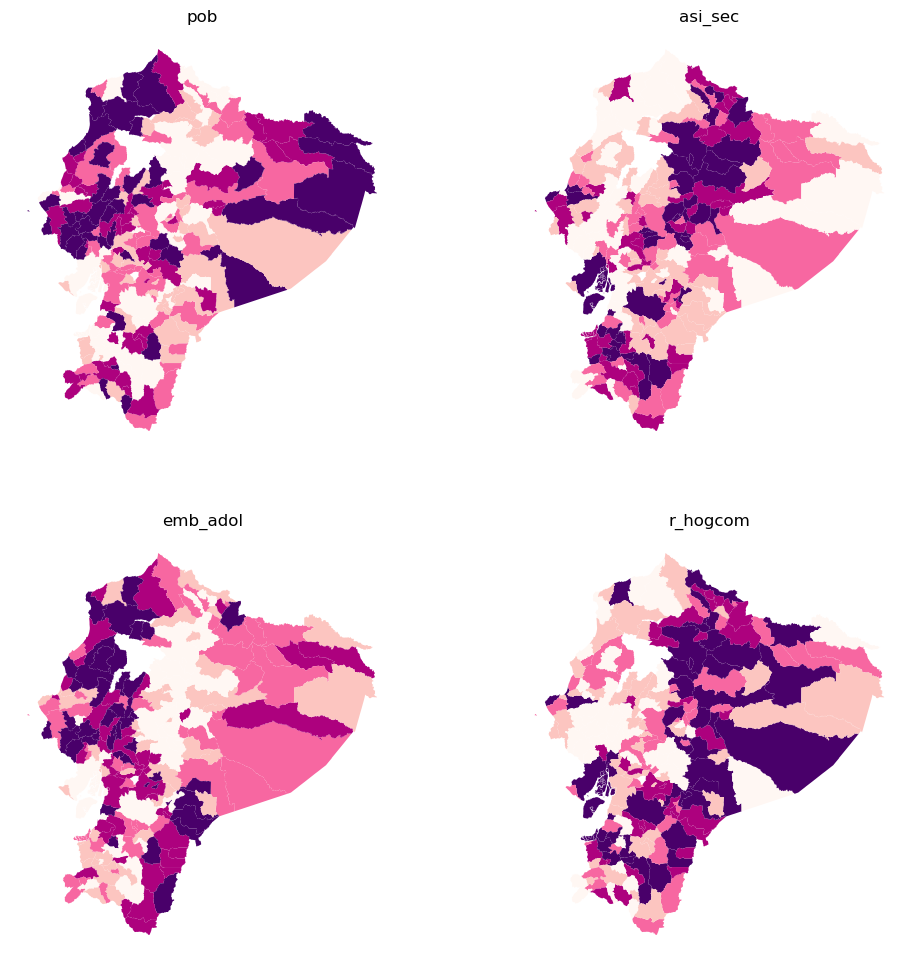

In [6]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()


A simple vista, se observan tanto **similitudes** como **diferencias** en la distribución espacial de estas variables. Algunas muestran una mayor concentración en ciertas regiones del país, mientras que otras presentan una variabilidad espacial distinta. Estas diferencias son clave para el análisis con clustering, ya que **cuando las variables tienen distribuciones espaciales distintas, aportan información complementaria** a los perfiles de cada conglomerado.

La visualización de los mapas de coropletas permite identificar patrones territoriales distintos para cada una de las variables analizadas del Censo 2010. Estos patrones aportan evidencia inicial sobre las desigualdades espaciales presentes en los cantones del Ecuador:

- **`pob` (Necesidades Básicas Insatisfechas - NBI):**  
  Se observa una concentración elevada de NBI en varias zonas de la Sierra central y el norte de la Amazonía, lo que indica un mayor grado de precariedad en estas áreas. Las zonas con menor NBI se ubican principalmente en la región costa y algunos cantones amazónicos.

- **`asi_sec` (Asistencia a educación secundaria):**  
  Esta variable presenta una fuerte variabilidad territorial. Los niveles más altos de asistencia se concentran en cantones urbanos y del centro-norte del país. En contraste, los niveles más bajos se encuentran en zonas periféricas de la Amazonía y la costa sur.

- **`emb_adol` (Embarazo adolescente):**  
  El embarazo adolescente tiende a ser más elevado en cantones rurales y de la Sierra norte y sur, mientras que las zonas urbanas y costeras muestran valores más bajos. Esto refleja posibles brechas en acceso a salud sexual y reproductiva, así como diferencias culturales.

- **`r_hogcom` (Proporción de hogares con computador):**  
  La disponibilidad de computadoras es marcadamente mayor en cantones urbanos y de la Sierra central, mientras que en la Amazonía y en muchos cantones rurales del litoral los niveles son considerablemente bajos. Esta variable evidencia la brecha digital territorial.

**Cuando las variables muestran patrones espaciales diversos**, cada una aporta información única para construir perfiles diferenciados. Por el contrario, si los patrones fueran muy similares, la utilidad del análisis por conglomerados se vería limitada.

También es importante considerar la **autocorrelación espacial** de estas variables, ya que influye directamente en la configuración territorial de los clústeres y puede indicar la existencia de estructuras espaciales subyacentes que deben ser tenidas en cuenta en procesos de regionalización.


El estadístico **Moran’s I** permite medir la **autocorrelación espacial global**, es decir, cuán similares son los valores entre cantones vecinos. Para calcularlo, se define una matriz de pesos espaciales; en este caso, se usará la **contigüidad tipo "queen"**, que considera vecinos a los cantones que comparten frontera o vértice. Esta herramienta complementa el análisis visual con una medida cuantitativa del patrón espacial.


In [8]:
w = Queen.from_dataframe(db,use_index = False)


Procedemos ahora a calcular el estadístico **Moran’s I** para cada una de las variables seleccionadas del censo. Esto nos permitirá cuantificar el grado en que cada variable presenta **estructura espacial**, es decir, si los valores tienden a agruparse geográficamente o si están distribuidos al azar en el territorio.

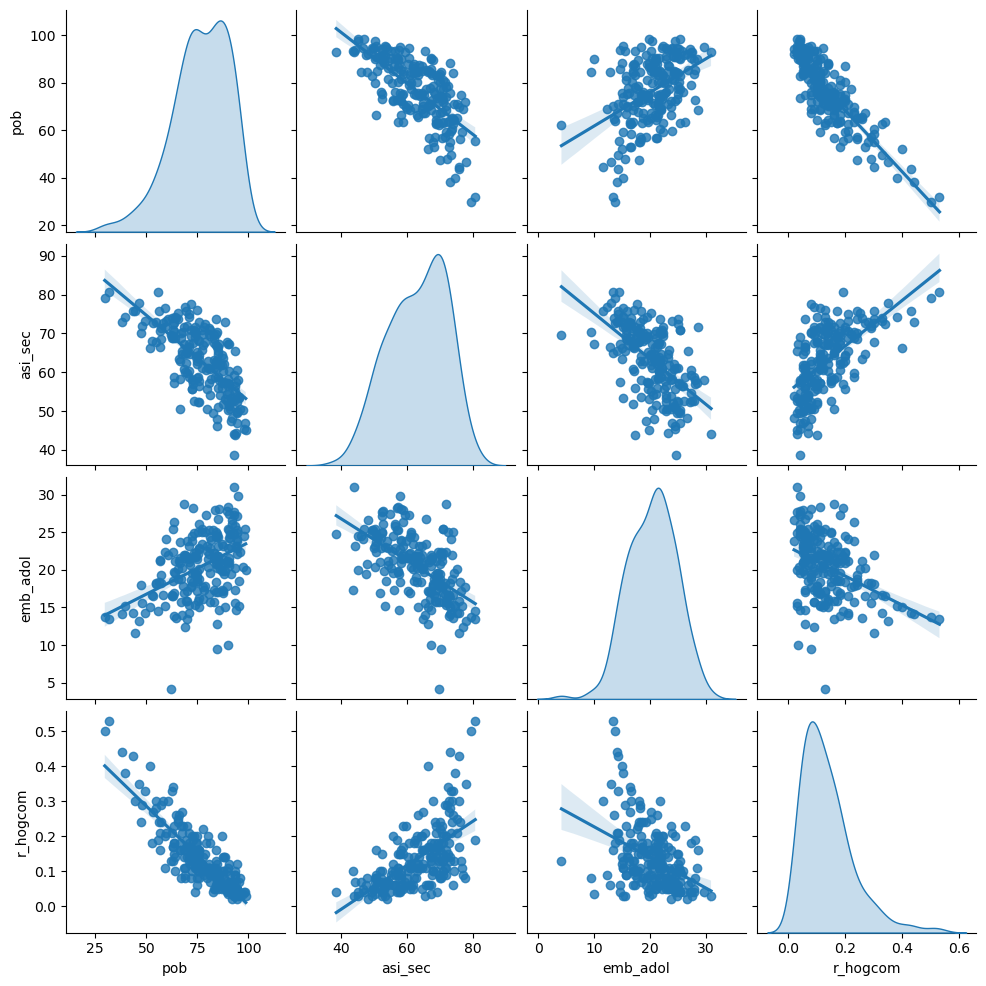

In [10]:
# Establece una semilla para la generación de números aleatorios.
# Esto asegura que cualquier proceso aleatorio en la ejecución posterior (como permutaciones en Moran's I) sea reproducible.
np.random.seed(123456)

# Calcula el índice de autocorrelación espacial global de Moran (Moran's I) para cada variable incluida en el análisis.
# 'db' es un DataFrame con las variables de interés.
# 'w' es una matriz de pesos espaciales (Spatial Weights Matrix), que define la vecindad entre observaciones.
mi_results = [
    Moran(db[variable], w) for variable in cluster_variables
]

# Reestructura los resultados obtenidos anteriormente como una lista de tuplas.
# Cada tupla contiene: el nombre de la variable, el valor de Moran's I y su p-valor obtenido por simulación (permutaciones).
# 'zip' une cada nombre de variable con su resultado respectivo.
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]

# Convierte la lista de resultados en un DataFrame de pandas.
# La tabla resultante tiene columnas: Variable, Moran’s I, y P-value.
# Se establece la columna "Variable" como índice del DataFrame para facilitar su visualización y ordenamiento.
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")

# Muestra la tabla con los resultados de Moran's I para cada variable.
print(table)

# Crea una gráfica de dispersión por pares (pairplot) con regresión lineal ajustada entre cada par de variables.
# Esto permite observar posibles relaciones lineales entre las variables utilizadas para el clustering.
# La diagonal muestra estimaciones de densidad (kde) de cada variable.
_ = sns.pairplot(
    db[cluster_variables], kind="reg", diag_kind="kde"
)


La **matriz de dispersión** incluye dos tipos de gráficos que nos ayudan a comprender mejor las variables utilizadas:

- En la **diagonal**, se muestran las **funciones de densidad** de cada variable, lo que permite examinar su distribución univariada y detectar posibles asimetrías, sesgos o valores extremos.

- En las **celdas fuera de la diagonal**, se presentan **gráficos de dispersión bivariados** que ilustran las asociaciones entre pares de variables, ayudando a identificar correlaciones o patrones conjuntos.

Este análisis es especialmente relevante en aplicaciones de **clustering**, donde las **distancias estadísticas** entre observaciones determinan qué tan similares o diferentes son. Dado que las distancias son sensibles a la **escala de las variables**, es fundamental considerar la estandarización de los datos. De lo contrario, una variable con unidades más grandes podría dominar el resultado del agrupamiento.

Por ejemplo, si se comparan observaciones solo con dos variables como el precio de la vivienda y el coeficiente de Gini, la escala de cada una puede influir significativamente en la distancia calculada entre puntos y, por tanto, en la formación de clústeres.



In [11]:
db[["pob", "asi_sec"]].head()

pob    asi_sec
0  38.197730  72.976674
1  63.392641  57.124268
2  69.296506  62.396501
3  87.824880  57.517794
4  70.077992  64.838618

El clustering se basa en la **distancia entre observaciones**, que indica qué tan similares son en función de las variables analizadas. Estas distancias pueden calcularse fácilmente con herramientas como **scikit-learn**:



In [13]:
from sklearn import metrics


metrics.pairwise_distances(
    db[["pob", "tot_hog"]].head()
).round(4)

array([[     0.    , 130376.0024, 122907.0039, 129714.0095, 126967.004 ],
       [130376.0024,      0.    ,   7469.0023,    662.4507,   3409.0066],
       [122907.0039,   7469.0023,      0.    ,   6807.0252,   4060.0001],
       [129714.0095,    662.4507,   6807.0252,      0.    ,   2747.0573],
       [126967.004 ,   3409.0066,   4060.0001,   2747.0573,      0.    ]])

En este caso, sabemos que la tasa de probreza `pob` está medida entre cero y uno mientas que el total de hogares es un conteo. Vemos que el valor de la distancia está dominada por el valor del número de hogares.


Antes de aplicar clustering, es importante **escalar las variables** para que las distancias entre observaciones no estén influenciadas por sus unidades o magnitudes. Existen diferentes métodos de estandarización, cada uno con su utilidad según las características de los datos:

- **Estandarización clásica (`scale()`)**  
  Utiliza la media y desviación estándar:

$$
  z = \frac{x_i - \bar{x}}{\sigma_x}
$$

- **Estandarización robusta (`robust_scale()`)**  
  Es útil cuando hay valores atípicos, ya que usa la mediana y el rango intercuartílico:

$$
  z = \frac{x_i - \tilde{x}}{[x]_{75} - [x]_{25}}
$$

- **Reescalado entre 0 y 1 (`minmax_scale()`)**  
  Útil para garantizar que los valores estén en un rango fijo:

$$
  z = \frac{x - \min(x)}{\max(x) - \min(x)}
$$

En este análisis usaremos `robust_scale()` para reducir el efecto de valores extremos y asegurar una comparación justa entre variables.




In [14]:
from sklearn.preprocessing import robust_scale
db_scaled = robust_scale(db[cluster_variables])

El análisis univariado y bivariado es útil como punto de partida, pero para detectar **patrones multivariados** necesitamos ir más allá. El **clustering** nos permite identificar grupos de observaciones similares considerando todas las variables al mismo tiempo.


## Clústers geodemográficos en cantones de Ecuador


El **clustering geodemográfico** agrupa áreas geográficas según sus características socioeconómicas usando técnicas multivariadas. El resultado se resume en mapas donde cada zona recibe una etiqueta de clúster. Esto permite visualizar y analizar patrones territoriales complejos de forma simplificada. Usaremos los métodos **k-means** y **Ward** para ilustrarlo.

### Kmeans

**K-means** es uno de los algoritmos de clustering más utilizados. Agrupa las observaciones en un número predefinido de **clústeres**, buscando que cada observación esté más cerca de la media de su propio grupo que de la de cualquier otro.

El algoritmo funciona de forma iterativa:

1. Se asignan aleatoriamente etiquetas a todas las observaciones.
2. Se calcula la **media multivariada** (centroide) de cada clúster.
3. Cada observación se reasigna al clúster cuya media esté más cerca.
4. Se repiten los pasos hasta que no haya más reasignaciones.

Este proceso requiere definir **cuántos clústeres (k)** queremos formar, lo cual no suele conocerse de antemano. Para este ejercicio, usaremos un valor de `k` arbitrario con la función `KMeans` de `scikit-learn`.



In [17]:
from sklearn.cluster import KMeans

En `scikit-learn`, aplicar k-means es sencillo: se crea un objeto `KMeans` indicando el número de clústeres. Este enfoque es representativo, ya que la mayoría de algoritmos en esta librería siguen la misma lógica de uso.


In [18]:
# Se inicia instancia Kmeans
kmeans = KMeans(n_clusters=5)


Se fija una **semilla** y se aplica `.fit()` para ejecutar k-means sobre los datos escalados.


In [19]:
# Se fija la semilla
np.random.seed(1234)
# Ajustamos el algoritmo K-Means
k5cls = kmeans.fit(db_scaled)


El vector `labels_` muestra el clúster asignado a cada observación.


In [20]:
# Se imprime las primeros 5 etiquetas
k5cls.labels_[:5]

array([3, 2, 2, 0, 1], dtype=int32)

Se puede ver que la primera observación fue asignada al cluster 3, la segunda y la tercera al cluster 2 y así sucesivamente. 

Las etiquetas numéricas (`0`, `1`, `2`, etc.) **no tienen valor ordinal**, solo indican pertenencia a un clúster. Para entender cada grupo, es necesario analizar sus perfiles. Antes de eso, visualizaremos los resultados en un **mapa**.


### Distribución espacial de los clusters

El mapa muestra la **distribución espacial** de los clústeres, permitiendo ver si áreas con perfiles similares están cerca entre sí.


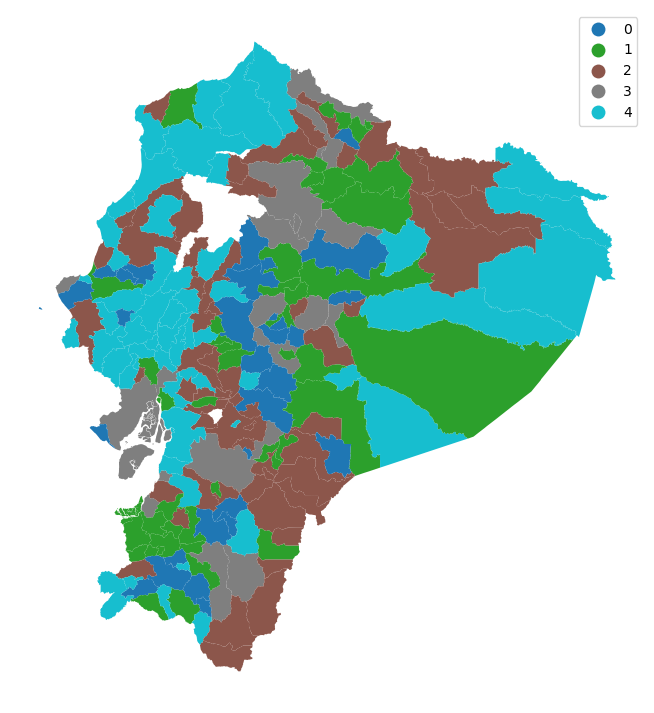

In [22]:
# Se asignan etiquetas en una columna
db["k5cls"] = k5cls.labels_
# Se configura la gráfica y el eje
f, ax = plt.subplots(1, figsize=(9, 9))
# Se grafican valores únicos que incluyen 
# una leyenda sin líneas de bordes
db.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Se quitan los ejes
ax.set_axis_off()
# Se muestra el mapa
plt.show()


El mapa sugiere que cantones cercanos comparten clúster, apoyando la ley de Tobler. Pero como los cantones varían en tamaño, la interpretación visual puede ser engañosa. Es necesario complementar con análisis adicionales.


### Análisis estadístico de un mapa de clústers

Para complementar el mapa, es útil analizar las **características estadísticas** de cada clúster. Esto permite entender qué observaciones lo componen y qué atributos las definen. Un primer paso es revisar la **cantidad de cantones** asignados a cada grupo (cardinalidad), lo que ayuda a interpretar el significado de las etiquetas generadas.


In [24]:
# se cuenta el número de cantones por clúster
k5sizes = db.groupby("k5cls").size()
k5sizes

k5cls
0    30
1    47
2    58
3    19
4    55
dtype: int64

Los clústers 2 y 4 son los que más concentran cantones, siendo el clúster 3 el que tiene menos cantones. 


Usamos la operación `dissolve` de **geopandas** para **unir los cantones de cada clúster** en un solo polígono. Esto permite calcular el **área total** ocupada por cada grupo en el territorio nacional y comparar su distribución espacial en términos de superficie, no solo de cantidad de observaciones.


In [26]:
# Se "disuelven" áreas por clúster, se agrega con la suma
areas = db.dissolve(by="k5cls", aggfunc="sum")["area_sqm"]
areas

k5cls
0    21876.948672
1    54891.693386
2    57829.763583
3    26800.637853
4    78586.684716
Name: area_sqm, dtype: float64

       No. Cantones       Area
k5cls                         
0         14.354067   9.115937
1         22.488038  22.872899
2         27.751196  24.097168
3          9.090909  11.167597
4         26.315789  32.746399


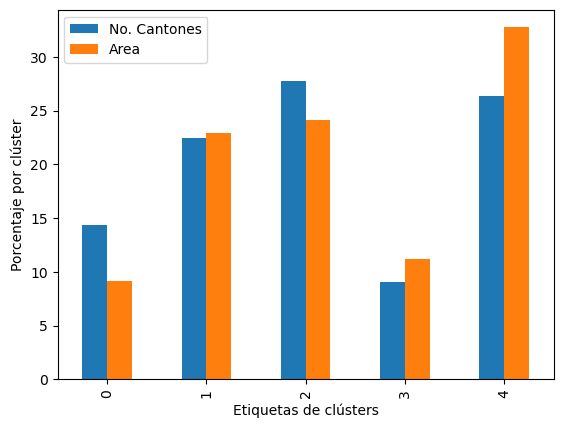

In [33]:
# Se juntan los datos de tamaño de cluster y su área
area_tracts = pd.DataFrame({"No. Cantones": k5sizes, "Area": areas})
# Se convierten los valores en porcentajes
area_tracts = area_tracts * 100 / area_tracts.sum()
print(area_tracts)
# Bar plot
ax = area_tracts.plot.bar()
# Se renombran los axes
ax.set_xlabel("Etiquetas de clústers")
ax.set_ylabel("Porcentaje por clúster");

El cluster 0 tiene un menor porcentaje de área comparado con el número de cantones que contiene, al tiempo que el cluster 4 representa un peso mayo en área de lo que representa el número de catones que contiene.

In [32]:
areas[1] / areas.sum()

np.float64(0.22872899066059615)


Calculamos la **media de cada variable** en cada clúster para darle sentido a las etiquetas y describir sus características comunes.


In [36]:
# Agrupar la tabla por la etiqueta del clúster, conservar las variables 
# utilizadas para el agrupamiento y obtener su media
k5means = db.groupby("k5cls")[cluster_variables].mean()

# Transponer la tabla y mostrarla redondeando cada valor a tres decimales
k5means.T.round(3)

k5cls          0       1       2       3       4
pob       84.241  67.114  75.698  49.217  90.306
asi_sec   64.648  70.761  62.460  73.437  52.519
emb_adol  16.559  17.527  22.875  15.857  23.868
r_hogcom   0.085   0.177   0.136   0.347   0.058

Usamos **valores originales** (no escalados) para construir los perfiles, ya que son **más fáciles de interpretar** y conectar con la realidad. Por ejemplo, se podría interpretar que el cluster 4 es que tiene los desafíos más importantes en términos de desarrollo puesto que sus indicadores son los más afectados. Por otro lado, el cluster 3 muestra los indicadores más destacados entre todos los grupos. 

Para facilitar la interpretación, es preferible usar **valores originales** en los perfiles. Sin embargo, también es posible expresarlos en términos **escalados** si se desea comparar la intensidad relativa de cada variable entre clústeres.


Aunque las medias ayudan a resumir los perfiles, pueden ocultar variaciones importantes o dar impresiones equivocadas. Para un análisis más completo, se puede usar el comando `describe` de **pandas** agrupando por clúster, lo que permite ver medidas como mediana, rango y cuartiles.


In [37]:
#-----------------------------------------------------------#
# Código ilustrativo solamente, no se ejecuta
#-----------------------------------------------------------#

# Agrupar la tabla por la etiqueta del clúster, conservar las variables 
# utilizadas para el agrupamiento y obtener su resumen descriptivo
k5desc = db.groupby('k5cls')[cluster_variables].describe()

# Recorrer cada clúster e imprimir una tabla con los estadísticos descriptivos
for cluster in k5desc.T:
    print('\n\t---------\n\tClúster %i' % cluster)
    print(k5desc.T[cluster].unstack())
#-----------------------------------------------------------#



	---------
	Clúster 0
          count       mean       std        min        25%        50%  \
pob        30.0  84.240680  6.219487  68.678320  80.573267  84.813252   
asi_sec    30.0  64.647845  5.664312  51.791908  61.007838  66.799827   
emb_adol   30.0  16.558611  2.591521   9.523810  15.314418  17.011340   
r_hogcom   30.0   0.085151  0.031879   0.030000   0.060000   0.090000   

                75%        max  
pob       87.800229  95.523083  
asi_sec   68.382811  72.905247  
emb_adol  17.910448  20.461095  
r_hogcom   0.107500   0.140000  

	---------
	Clúster 1
          count       mean       std        min        25%        50%  \
pob        47.0  67.114416  6.696291  52.908381  63.067536  67.231203   
asi_sec    47.0  70.761435  4.045082  62.115719  68.626115  70.468264   
emb_adol   47.0  17.527434  3.352314   4.166667  15.764672  17.841410   
r_hogcom   47.0   0.177234  0.049065   0.080000   0.140000   0.180000   

                75%        max  
pob       71.877759  81.

El uso de estadísticas detalladas puede generar un exceso de números difíciles de interpretar. Una mejor alternativa es **visualizar las distribuciones** de las variables por clúster. Para ello, es necesario **reorganizar los datos** en formato largo ("tidy") que facilite la generación de gráficos comparativos.


In [38]:
# Indexar el DataFrame `db` usando el identificador del clúster
tidy_db = db.set_index("k5cls")

# Conservar únicamente las variables utilizadas para el agrupamiento
tidy_db = tidy_db[cluster_variables]

# Apilar los nombres de las columnas en una sola columna,
# obteniendo una versión "larga" del conjunto de datos
tidy_db = tidy_db.stack()

# Convertir los índices en columnas normales
tidy_db = tidy_db.reset_index()

# Renombrar las columnas
tidy_db = tidy_db.rename(
    columns={"level_1": "Atributo", 0: "Valor"}
)

# Mostrar las primeras filas del resultado
tidy_db.head()


k5cls  Atributo      Valor
0      3       pob  38.197730
1      3   asi_sec  72.976674
2      3  emb_adol  14.170208
3      3  r_hogcom   0.440000
4      2       pob  63.392641

Con los datos reorganizados, podemos generar gráficos que muestren la **distribución de valores por clúster y por variable**. Esto proporciona un perfil más completo y visual de cada grupo, permitiendo comparar no solo promedios, sino también la forma y dispersión de los datos dentro de cada clúster.


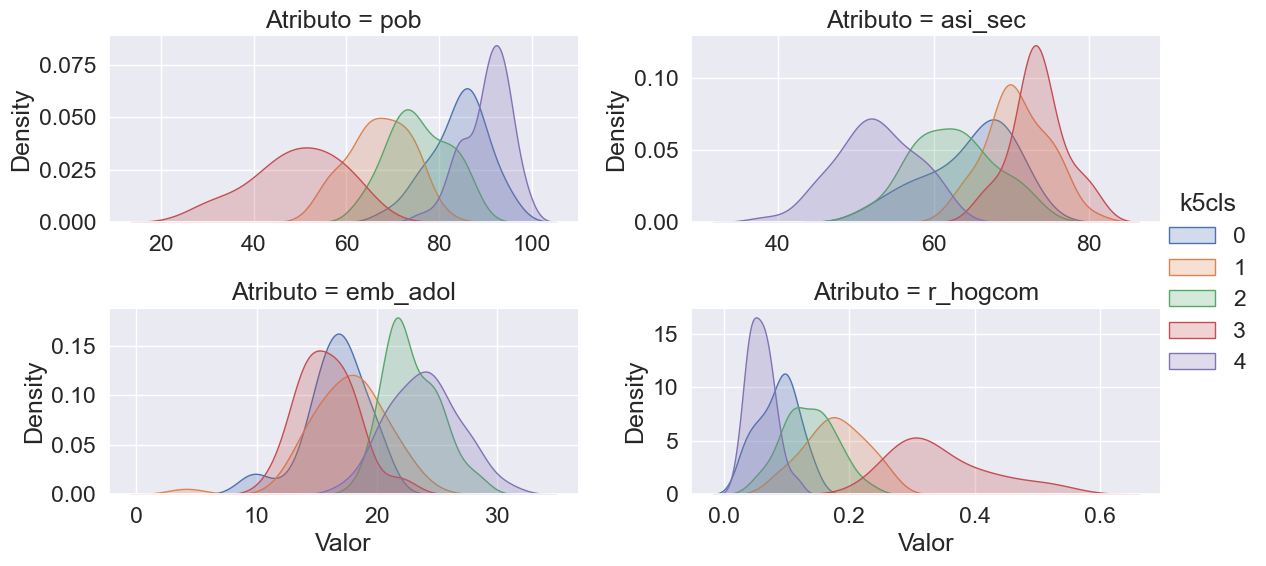

In [46]:
# Escalar las fuentes para que sean más legibles
sns.set(font_scale=1.5)

# Configurar los paneles (facetas)
facets = sns.FacetGrid(
    data=tidy_db,       # Usar el DataFrame en formato largo
    col="Atributo",    # Crear una columna de gráfico por atributo
    hue="k5cls",        # Colorear según el clúster
    sharey=False,       # No compartir eje Y entre facetas
    sharex=False,       # No compartir eje X entre facetas
    aspect=2,           # Relación de aspecto horizontal
    col_wrap=2          # Número de gráficos por fila
)

# Construir los gráficos usando `kdeplot` (densidad)
_ = facets.map(sns.kdeplot, "Valor", fill=True).add_legend()


Utilizamos la funcionalidad de **facetas de `seaborn`** para crear múltiples gráficos organizados automáticamente según los datos. El proceso tiene dos pasos:

1. Se define la estructura general de los gráficos (facetas) según las variables y los clústeres.
2. Se aplica una función, como `seaborn.kdeplot`, para trazar la **distribución** de cada variable dentro de cada clúster.

Esto permite visualizar de forma clara y comparativa los perfiles completos de los clústeres.


## Clustering jerárquico aglomerativo (AHC)

El **clustering jerárquico aglomerativo** (AHC) construye una jerarquía de soluciones que va desde cada observación como su propio clúster, hasta un único grupo que contiene todos los datos. Lo útil está en los niveles intermedios, donde se encuentran agrupamientos con distintos niveles de detalle.

El algoritmo sigue una lógica simple:

1. Cada observación comienza como su propio clúster.
2. Se identifican las dos observaciones más cercanas (según una métrica de distancia, como la euclidiana).
3. Se unen en un nuevo clúster.
4. Se repite el proceso hasta alcanzar el número deseado de clústeres.

El nombre “aglomerativo” se debe a que va **fusionando clústeres pequeños en otros más grandes**. Al igual que en k-means, es necesario especificar cuántos clústeres se quiere obtener.

En Python, AHC se implementa fácilmente con **`scikit-learn`**, siguiendo una lógica muy similar a la usada en k-means. El primer paso es importar el algoritmo.


In [47]:
from sklearn.cluster import AgglomerativeClustering

Usamos la clase `AgglomerativeClustering` de `scikit-learn` y aplicamos el método `.fit()` sobre los datos para ejecutar el algoritmo y obtener los clústeres jerárquicos.


In [49]:
# Fijar la semilla para asegurar la reproducibilidad
np.random.seed(0)

# Inicializar el algoritmo de agrupamiento jerárquico (aglomerativo)
model = AgglomerativeClustering(linkage="ward", n_clusters=5)

# Ejecutar el algoritmo de clustering sobre los datos escalados
model.fit(db_scaled)

# Asignar las etiquetas de clúster al DataFrame original
db["ward5"] = model.labels_

Al igual que con k-means, podemos revisar cuántas observaciones fueron asignadas a cada clúster generado por AHC. 

In [51]:
ward5sizes = db.groupby("ward5").size()
ward5sizes

ward5
0    82
1    56
2    46
3     9
4    16
dtype: int64

También podemos calcular la **media de cada variable** dentro de los clústeres obtenidos con AHC.

In [52]:
ward5means = db.groupby("ward5")[cluster_variables].mean()
ward5means.T.round(3)

ward5          0       1       2       3       4
pob       88.034  71.626  74.617  41.692  58.537
asi_sec   55.053  64.575  70.098  75.088  71.302
emb_adol  23.208  21.728  15.702  13.865  18.403
r_hogcom   0.070   0.158   0.128   0.407   0.278

Ahora hacemos `tidy` nuestro conjunto de datos:

In [53]:
# Indexar el DataFrame `db` usando el identificador del clúster jerárquico "ward5"
tidy_db = db.set_index("ward5")

# Conservar únicamente las variables utilizadas para el agrupamiento
tidy_db = tidy_db[cluster_variables]

# Apilar los nombres de las columnas en una sola columna,
# obteniendo una versión "larga" del conjunto de datos
tidy_db = tidy_db.stack()

# Convertir los índices en columnas normales
tidy_db = tidy_db.reset_index()

# Renombrar las columnas
tidy_db = tidy_db.rename(
    columns={"level_1": "Atributo", 0: "Valor"}
)

# Mostrar las primeras filas del resultado
tidy_db.head()


ward5  Atributo      Valor
0      3       pob  38.197730
1      3   asi_sec  72.976674
2      3  emb_adol  14.170208
3      3  r_hogcom   0.440000
4      1       pob  63.392641

Y hacemos un gráfico de los perfiles:

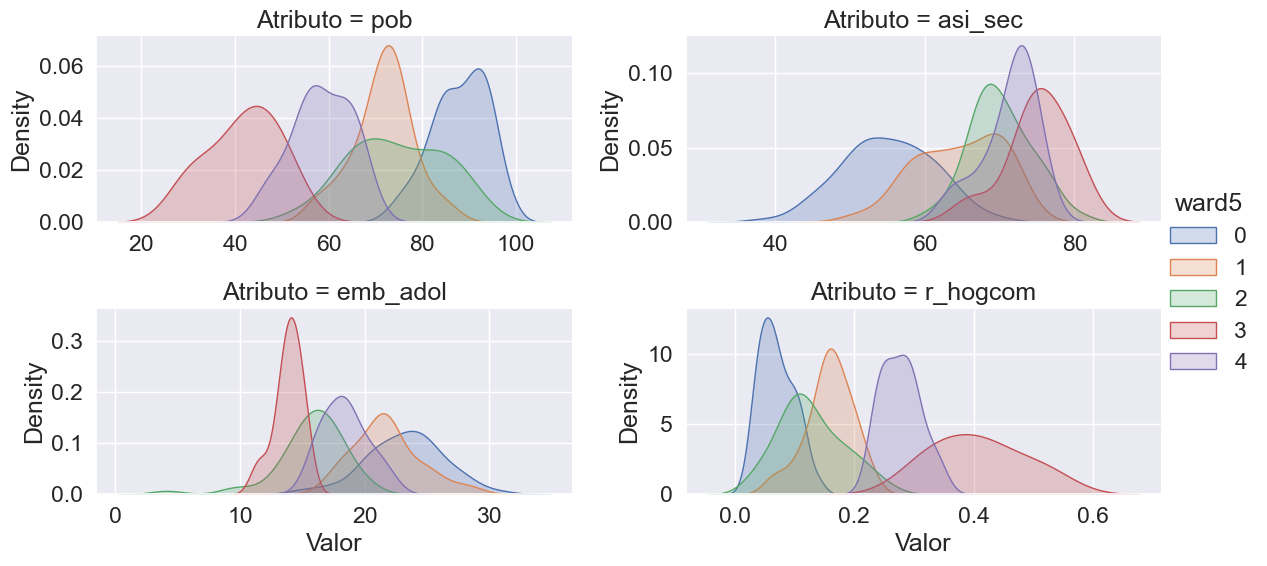

In [58]:
# Configurar los paneles (facetas) para graficar por atributo
facets = sns.FacetGrid(
    data=tidy_db,       # Usar el DataFrame en formato largo
    col="Atributo",    # Crear una faceta (gráfico separado) por cada atributo
    hue="ward5",        # Diferenciar por clúster jerárquico (ward5) con colores
    sharey=False,       # No compartir el eje Y entre los gráficos
    sharex=False,       # No compartir el eje X entre los gráficos
    aspect=2,           # Relación de aspecto horizontal para hacer los gráficos más anchos
    col_wrap=2          # Ajustar para mostrar 3 gráficos por fila
)

# Construir los gráficos de densidad (`kdeplot`) y agregar la leyenda
facets.map(sns.kdeplot, "Valor", fill=True).add_legend();


La interpretación de los gráficos anteriores es similar al caso kmeans.


Para analizar la dimensión geográfica del resultado de AHC, generamos un **mapa de clústeres**. Para facilitar la comparación, colocamos este mapa junto al generado por k-means, lo que permite observar similitudes y diferencias en la distribución espacial de los grupos formados por ambos métodos.


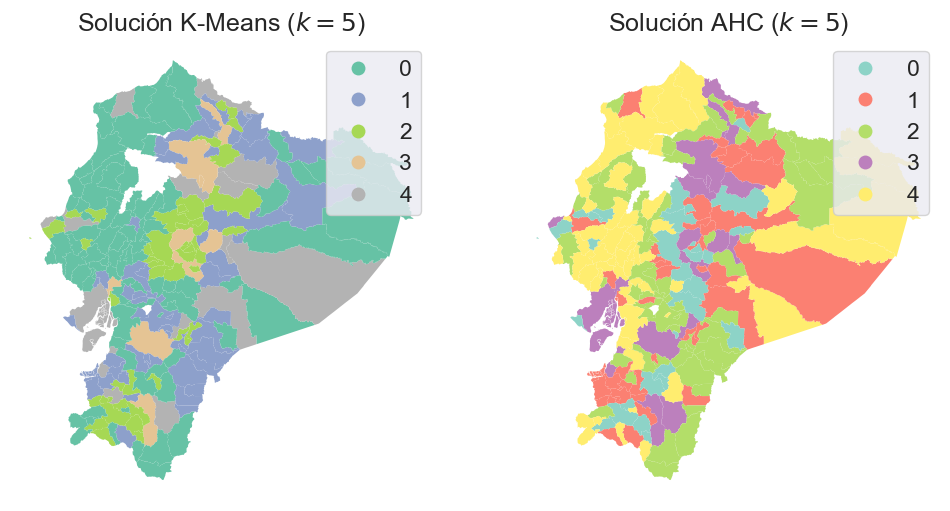

In [59]:
# Asignar etiquetas del modelo jerárquico al DataFrame
db["ward5"] = model.labels_

# Configurar la figura y los ejes para dos mapas uno al lado del otro
f, axs = plt.subplots(1, 2, figsize=(12, 6))

### K-Means ###
ax = axs[0]
# Graficar el mapa coroplético con los valores únicos de K-Means,
# incluyendo leyenda y sin líneas de borde
db.plot(
    column="ward5",         # Variable de clúster jerárquico
    categorical=True,       # Tratar los valores como categorías
    cmap="Set2",            # Colores para distinguir clústeres
    legend=True,            # Mostrar leyenda
    linewidth=0,            # Sin bordes entre polígonos
    ax=ax,                  # Graficar en el primer eje
)
# Eliminar los ejes del gráfico
ax.set_axis_off()
# Agregar título
ax.set_title("Solución K-Means ($k=5$)")

### AHC (Clustering Jerárquico Aglomerativo) ###
ax = axs[1]
# Graficar el mapa coroplético con los valores únicos de AHC
db.plot(
    column="k5cls",         # Variable de clúster generada por K-Means
    categorical=True,
    cmap="Set3",
    legend=True,
    linewidth=0,
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Solución AHC ($k=5$)")

# Mostrar el mapa
plt.show()


Aunque debemos tener presente que los polígonos irregulares pueden distorsionar la percepción visual, la comparación entre los mapas de **k-means** y **AHC** revela que ambos capturan una **estructura espacial similar**.

Sin embargo, en ambos casos los clústeres presentan **componentes desconectados**, lo que implica una **violación parcial de la ley de Tobler**: las áreas que pertenecen al mismo clúster no están necesariamente juntas en el espacio. Para recorrer todas las zonas de un mismo grupo, habría que pasar por territorios asignados a otros clústeres. Esto refleja que los algoritmos agrupan según las **similitudes estadísticas**, sin considerar la **proximidad geográfica**.


## Regionalización: agrupamiento jerárquico con restricciones espaciales

### Restricción de contigüidad

Cuando se necesita que los grupos sean **contiguos geográficamente**, se usa la **regionalización**, un tipo de clustering que incorpora una **restricción espacial**. Así, cada región agrupa unidades similares en atributos y además conectadas entre sí.

Este enfoque es útil para delimitar áreas como vecindarios o zonas censales. En `scikit-learn`, se puede aplicar añadiendo la **matriz de pesos espaciales** al algoritmo AHC, lo que asegura que solo se agrupen unidades vecinas.


In [60]:
# Fijar la semilla para asegurar la reproducibilidad
np.random.seed(123456)

# Especificar el modelo de clustering con restricción espacial
model = AgglomerativeClustering(
    linkage="ward",           # Método de enlace: Ward (minimiza la varianza)
    connectivity=w.sparse,    # Restricción de conectividad espacial (grafo de pesos)
    n_clusters=5              # Número de clústeres deseado
)

# Ajustar el algoritmo a los datos escalados
model.fit(db_scaled)


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1096 stored elements and shape (209, 209)>,
                        n_clusters=5)

Inspeccionemos el resultado de manera gráfica:

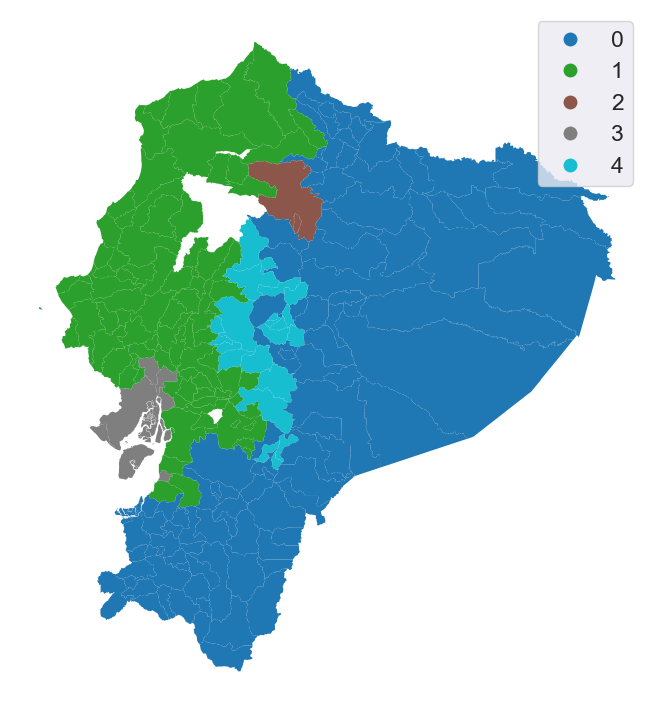

In [61]:
# Asignar las etiquetas del modelo con restricción espacial al DataFrame
db["ward5wq"] = model.labels_

# Configurar la figura y el eje para el mapa
f, ax = plt.subplots(1, figsize=(9, 9))

# Graficar un mapa coroplético de los clústeres con valores únicos,
# incluyendo la leyenda y sin líneas de borde entre polígonos
db.plot(
    column="ward5wq",     # Columna con los clústeres obtenidos (con restricción espacial)
    categorical=True,     # Tratar los valores como categorías
    legend=True,          # Mostrar la leyenda
    linewidth=0,          # No mostrar bordes entre polígonos
    ax=ax,                # Dibujar en el eje configurado
)

# Eliminar los ejes del gráfico
ax.set_axis_off()

# Mostrar el mapa
plt.show()


La introducción de la restricción espacial da como resultado clústeres completamente conectados con distribuciones espaciales mucho más concentradas.


### Cambiando la restricción espacial

La **restricción espacial** en los algoritmos de regionalización se basa en la **matriz de pesos espaciales** utilizada. Por tanto, una pregunta clave es cómo la elección de esta matriz **afecta la forma final de las regiones**.

Podemos explorar este efecto comparando dos configuraciones:

- Una matriz de **contigüidad tipo Queen**, que conecta unidades que comparten frontera o vértice.
- Una matriz de **vecinos más cercanos (k-NN)**, donde cada unidad se conecta con sus **cuatro vecinos más próximos**, sin importar si se tocan.

Al mantener los mismos datos y solo cambiar la matriz de conectividad, podemos observar directamente cómo varía la estructura de las regiones resultantes.


In [62]:
w = KNN.from_dataframe(db, k=4)

Usando la matriz k-NN, que conecta cada unidad con sus **cuatro vecinos más cercanos**, ejecutamos nuevamente el algoritmo AHC con restricción espacial.


In [65]:
# Fijar la semilla para asegurar la reproducibilidad
np.random.seed(123456)

# Especificar el modelo de clustering con restricción espacial
model = AgglomerativeClustering(
    linkage="ward",           # Método de enlace Ward: minimiza la varianza interna de los clústeres
    connectivity=w.sparse,    # Matriz de conectividad espacial (por ejemplo, vecinos contiguos)
    n_clusters=5              # Número de clústeres a formar
)

# Ajustar el algoritmo a los datos escalados
model.fit(db_scaled)


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 836 stored elements and shape (209, 209)>,
                        n_clusters=5)

Graficamos las regiones finales

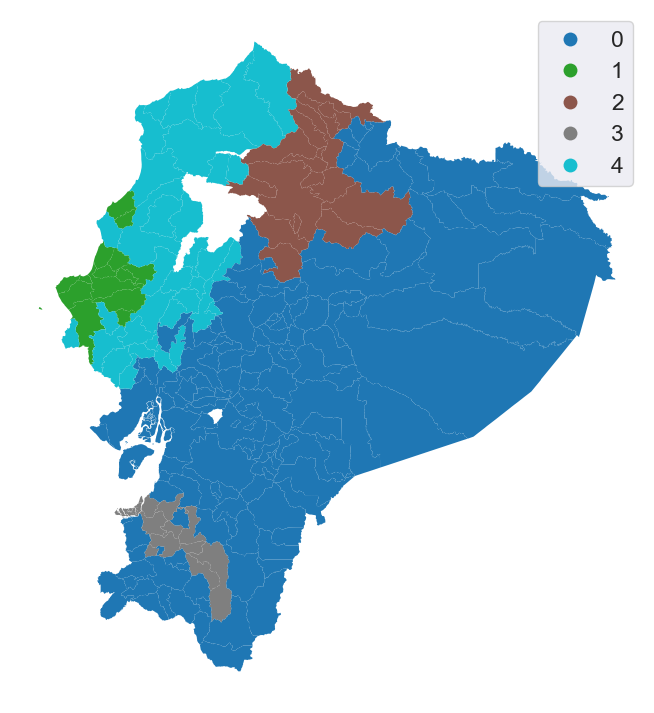

In [66]:
# Asignar las etiquetas del modelo con restricción espacial (por vecinos k más cercanos) al DataFrame
db["ward5wknn"] = model.labels_

# Configurar la figura y el eje para el mapa
f, ax = plt.subplots(1, figsize=(9, 9))

# Graficar el mapa coroplético de clústeres
# incluyendo la leyenda y sin líneas de borde
db.plot(
    column="ward5wknn",   # Columna que contiene los clústeres con restricción espacial (kNN)
    categorical=True,     # Tratar los valores como categorías (colores distintos por grupo)
    legend=True,          # Incluir leyenda de colores
    linewidth=0,          # Sin bordes entre polígonos
    ax=ax,                # Dibujar en el eje configurado
)

# Quitar los ejes del gráfico
ax.set_axis_off()

# Mostrar el mapa
plt.show()


Aunque se impuso una **restricción espacial** usando la matriz de **4 vecinos más cercanos (k-NN)**, esta restricción solo garantiza **conectividad dentro de esa estructura específica**. Sin embargo, en este caso, los clústeres obtenidos también resultan **conectados según la contigüidad Queen**, lo cual es una coincidencia favorable.

Entonces, ¿cuál regionalización es “mejor”?  
La calidad de una regionalización suele evaluarse en dos dimensiones:

- **Coherencia geográfica**: se analiza si los clústeres tienen tamaños y formas equilibradas y compactas.
- **Coherencia estadística**: mide si las observaciones son más similares a las de su propio clúster que a las de otros.

Por lo general, los algoritmos sin restricción espacial (como el clustering tradicional) logran **mejor ajuste estadístico**, mientras que los métodos de regionalización aseguran **mayor cohesión geográfica**. A continuación, compararemos ambas dimensiones.


### Coherencia geográfica

Una forma simple de evaluar la **coherencia geográfica** de una región es medir su **compacidad**. Una medida común es el **Cociente Isoperimétrico (IPQ)**, que compara el área de la región con la de un círculo que tiene el mismo perímetro.

La fórmula es:

$$
IPQ_i = \frac{A_i}{A_c} = \frac{4\pi A_i}{P_i^2}
$$

Donde:
- $A_i$ es el área de la región $i$,
- $P_i$ es el perímetro de la región $i$,
- $A_c$ es el área del círculo con perímetro igual a $P_i$.

Valores de **IPQ cercanos a 1** indican regiones **más compactas** (similares a un círculo). En cambio, valores cercanos a **0** reflejan formas **alargadas o irregulares**.

En clustering sin restricción espacial, se espera que el IPQ sea bajo, ya que los clústeres suelen ser fragmentados y con muchos bordes.

El cálculo se puede hacer con el área y el perímetro:


In [69]:
results = []

# Iterar sobre cada tipo de clúster
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # Calcular las regiones poligonales usando `dissolve`, agrupando por clúster
    regions = db[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    
    # Calcular el cociente isoperimétrico (IPQ) real para estas regiones
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    
    # Convertir a DataFrame
    result = ipqs.to_frame(cluster_type)
    
    # Guardar el resultado en la lista
    results.append(result)

# Apilar todas las series de IPQ juntas como columnas
pd.concat(results, axis=1)


k5cls     ward5   ward5wq  ward5wknn
0  0.019121  0.013290  0.046850   0.032577
1  0.014615  0.011367  0.043125   0.097703
2  0.011265  0.016529  0.223763   0.112968
3  0.014462  0.035831  0.027667   0.057976
4  0.014781  0.018682  0.044673   0.051225

Los resultados muestran que las **regiones generadas por regionalización** tienen formas mucho **más compactas** que los clústeres sin restricción espacial. Sin embargo, esta mejora en la **coherencia geográfica** se logra a costa de una menor **bondad de ajuste estadístico**, como se verá más adelante.

Entre las dos regionalizaciones comparadas, las **regiones basadas en vecinos más cercanos (k-NN)** son **más compactas** que las construidas con **contigüidad Queen**. De hecho, la región más compacta del método Queen tiene un nivel de compacidad similar al valor medio de las regiones k-NN.

Existen muchas otras métricas para evaluar la **regularidad de formas**, varias de ellas disponibles en el módulo `esda.shapestats`, que también permite analizar la **sensibilidad** de cada medida a la forma geográfica de las regiones.


### Coherencia estadística (goodness of fit)


Para evaluar la **coherencia interna de los clústeres** desde el punto de vista estadístico, `scikit-learn` ofrece varias métricas en su módulo `metrics`, que ya se ha usado anteriormente para calcular distancias.

Dos medidas comunes son:

- **`calinski_harabasz_score()` (CH)**:  
  Calcula la **varianza intra-clúster** dividida por la **varianza entre clústeres**. Valores más altos indican una mejor separación entre grupos.

- **`silhouette_score()`**:  
  Mide la **distancia promedio estandarizada** de cada observación al clúster más similar que no le fue asignado. También, cuanto mayor el valor, mejor la separación entre clústeres.

Para calcular estas métricas, se necesita tanto el **conjunto de datos original** como las **etiquetas** generadas por el algoritmo de clustering. A continuación, se evaluará el **CH score** para cada una de las soluciones analizadas.


In [70]:
ch_scores = []

# Iterar sobre cada tipo de clúster
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # Calcular el puntaje de Calinski-Harabasz (CH)
    ch_score = metrics.calinski_harabasz_score(
        # Usar las variables escaladas
        robust_scale(db[cluster_variables]),
        # Usar las etiquetas de clúster correspondientes
        db[cluster_type],
    )
    # Agregar el tipo de clúster junto con su puntaje CH
    ch_scores.append((cluster_type, ch_score))

# Reorganizar los resultados en un DataFrame para mostrarlos
pd.DataFrame(
    ch_scores, columns=["tipo de clúster", "puntaje CH"]
).set_index("tipo de clúster")


puntaje CH
tipo de clúster            
k5cls            130.135331
ward5            116.617624
ward5wq           25.176627
ward5wknn         22.757841

En las funciones del módulo `metrics` de `scikit-learn`, los métodos que terminan en `score` indican **mejor ajuste cuanto mayor sea el valor**. En este caso, la solución **k-means** obtuvo el **mayor Calinski-Harabasz score**, seguida por el agrupamiento jerárquico **Ward**. Ambas regionalizaciones tuvieron puntajes **considerablemente más bajos**.

Esto confirma lo anticipado: **una mayor coherencia geográfica implica sacrificar ajuste estadístico**. Dado que la regionalización impone restricciones espaciales, **no puede alcanzar** el mismo nivel de ajuste interno que un método sin restricciones como k-means, salvo en casos excepcionales.


### Similaridad de la solución

El módulo `metrics` de `scikit-learn` también incluye herramientas para comparar si **diferentes algoritmos de clustering generan etiquetados similares**. Entre las más usadas están:

- **`adjusted_rand_score()`**: mide el grado de coincidencia entre dos agrupamientos, corrigiendo por azar.
- **`mutual_info_score()`**: evalúa cuánta información comparten dos etiquetados distintos.

Estas métricas permiten analizar si los distintos métodos —como k-means, Ward o regionalización— producen resultados similares o capturan estructuras diferentes en los datos.


In [79]:
ami_scores = []

# Para cada solución de agrupamiento
for i_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # Compararla con cada otra solución
    for j_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
        # Calcular el índice de información mutua ajustada (AMI) entre ambas
        ami_score = metrics.adjusted_mutual_info_score(
            db[i_cluster_type], db[j_cluster_type]
        )
        # Guardar la combinación de soluciones con su puntuación
        ami_scores.append((i_cluster_type, j_cluster_type, ami_score))

# Organizar los resultados en un DataFrame
results = pd.DataFrame(
    ami_scores, columns=["origen", "destino", "similaridad"]
)

# Transformar a una matriz cuadrada (formato ancho)
results.pivot(index="origen", columns="destino", values="similaridad")


destino       k5cls     ward5  ward5wknn   ward5wq
origen                                            
k5cls      1.000000  0.545118   0.163780  0.205028
ward5      0.545118  1.000000   0.158831  0.197453
ward5wknn  0.163780  0.158831   1.000000  0.283892
ward5wq    0.205028  0.197453   0.283892  1.000000

Los puntajes obtenidos muestran que **k-means y Ward** son los métodos que generan resultados **más similares entre sí**. En cambio, las dos regionalizaciones tienen **menor similitud** entre ellas, y en general, son **poco similares a los agrupamientos sin restricción**.

Esto es coherente con lo discutido anteriormente: las regionalizaciones están condicionadas por la geografía, mientras que los métodos como k-means se enfocan únicamente en la similitud estadística, lo que da lugar a soluciones distintas.


## Conclusión 


El **clustering** y la **regionalización** son herramientas complementarias para simplificar datos multivariados complejos y entender su **estructura espacial**. Cuando hay muchas variables, es difícil analizarlas una por una; por ello, estas técnicas agrupan observaciones con **perfiles similares**, permitiendo resumir la complejidad en categorías interpretables.

- El **clustering** forma grupos (clústeres) con características internas coherentes. Existen muchos métodos distintos que varían según cómo se define la similitud y cómo se construyen los grupos.
  
- La **regionalización** es un tipo especial de clustering que además impone una **restricción geográfica**: los elementos de cada grupo deben estar **espacialmente conectados**. Esto se logra usando estructuras como la matriz de contigüidad o la de vecinos más cercanos.

En general, la **regionalización produce agrupaciones más coherentes en el espacio**, pero con **menor ajuste estadístico**, lo que refleja una **compensación inevitable** entre precisión en los datos y coherencia territorial.

En este capítulo se abordaron los fundamentos conceptuales y prácticos de ambas técnicas, mostrando cómo aplicarlas con herramientas de ciencia de datos geográfica. Además, se destacó su vínculo con la **autocorrelación espacial**, ya que la estructura espacial y las covariaciones entre variables determinan los patrones detectados.

Tanto el clustering como la regionalización son herramientas clave para el análisis exploratorio, predictivo y explicativo en el trabajo del científico de datos geográfico.



## Preguntas

1. ¿Qué disciplinas aplican técnicas de regionalización? Menciona ejemplos concretos en cada caso.

2. ¿En qué se diferencian y se asemejan los conceptos de clúster y región?

3. Al evaluar la calidad de una regionalización, ¿cómo pueden usarse las métricas tradicionales de clustering? ¿Qué limitaciones tienen y qué aspectos adicionales deberían considerarse desde la perspectiva geográfica?

4. ¿Qué implicaciones tiene el número de componentes conexos en la matriz de pesos espaciales para el proceso de regionalización?

5. Supón que tienes dos matrices de pesos espaciales para aplicar un clustering con restricción geográfica. Ambas matrices conectan todas las unidades espaciales, pero difieren en su densidad (por ejemplo, la matriz Rook es menos densa que la Queen).

   a. ¿Cómo podría afectar la dispersión (sparsity) de la matriz de pesos a la calidad del clustering?  
   
   b. Usando `pysal.lib.weights.higher_order`, construye una matriz de segundo orden a partir de la matriz usada en este capítulo.  
   
   c. Compara el porcentaje de celdas no nulas (`pct_nonzero`) de ambas matrices.  
   
   d. Vuelve a ejecutar el análisis con esta nueva matriz de segundo orden. ¿Qué cambia?

6. Dado que los datos espaciales presentan dependencia espacial (las unidades cercanas tienden a parecerse más entre sí), ¿cómo cambiarían los resultados de clustering y regionalización si esta dependencia fuera muy fuerte y positiva, muy débil o muy fuerte y negativa?

7. Usando una grilla 20x20 con `w = pysal.lib.weights.lat2W(20, 20)`, ¿cuántas formas únicas existen para dividir el grafo en 20 regiones de 20 unidades cada una, asegurando que cada región sea un componente conexo? ¿Y cuántas formas únicas existirían si se usara `rook=False`?
